# Predicting Anemia in CKD Patients using XGBoost

In [3]:
import importlib
import subprocess
import sys

def install_if_missing(package, import_name=None):
    try:
        importlib.import_module(import_name or package)
    except ImportError:
        print(f"📦 Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

packages = [
    ("pandas", "pandas"),
    ("numpy", "numpy"),
    ("matplotlib", "matplotlib"),
    ("seaborn", "seaborn"),
    ("scikit-learn", "sklearn"),
    ("joblib", "joblib"),
    ("xgboost", "xgboost")
]

for pkg, imp in packages:
    install_if_missing(pkg, imp)


Import Libraries

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import joblib
import os

sns.set(style="whitegrid")


## Load and Explore Data

In [5]:
df = pd.read_csv("../data/clean/kidney_disease_cleaned.csv")
print("Anemia value counts:")
print(df["Anemia"].value_counts(dropna=False))


Anemia value counts:
Anemia
0.0    339
1.0     60
NaN      1
Name: count, dtype: int64


## Preprocessing

In [6]:
df = df.dropna(subset=["Anemia"])

features = [
    "Age", "Blood_Pressure", "Albumin", "Sugar", "Packed_Cell_Volume",
    "White_Blood_Cell_Count", "Red_Blood_Cell_Count", "Hemoglobin",
    "Sodium", "Potassium", "Serum_Creatinine", "Blood_Urea",
    "Blood_Glucose_Random"
]

features = [f for f in features if f in df.columns]
df[features] = df[features].fillna(df[features].median())

X = df[features]
y = df["Anemia"]


## Target Distribution

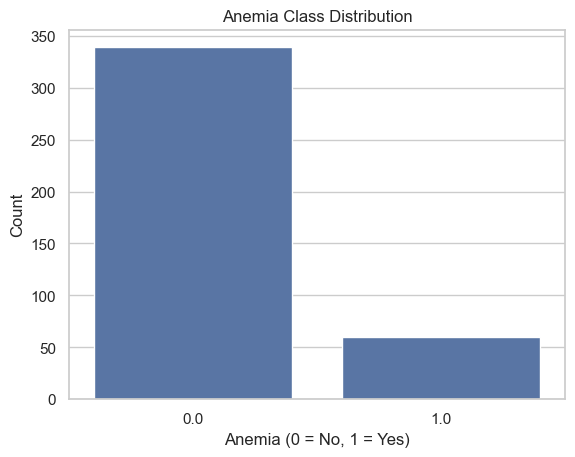

In [7]:
sns.countplot(x="Anemia", data=df)
plt.title("Anemia Class Distribution")
plt.xlabel("Anemia (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


## Train/Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train XGBoost Model

In [9]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)

c:\Users\mngyn\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:29:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Evaluation

Confusion Matrix:
[[66  2]
 [ 7  5]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.94        68
         1.0       0.71      0.42      0.53        12

    accuracy                           0.89        80
   macro avg       0.81      0.69      0.73        80
weighted avg       0.88      0.89      0.87        80



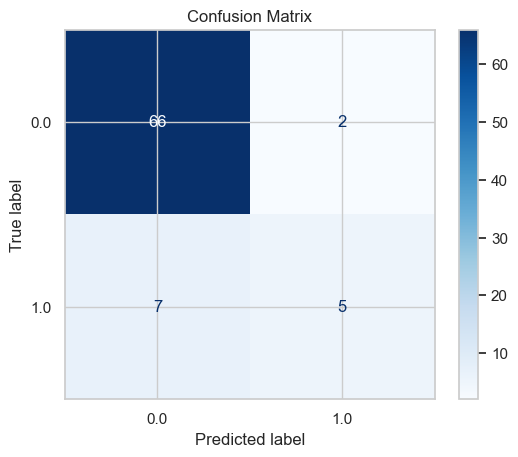

In [10]:
y_pred = model.predict(X_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### 📌 TL;DR (with relevant stats included)

The model performs really well overall with **89% accuracy**, but it’s clearly better at identifying patients **without anemia** than those **with it**.

- For **non-anemic patients (class 0)**:  
  - **Precision:** 90%  
  - **Recall:** 97%  
  - **F1-score:** 94%  
  It rarely misclassifies them — only **2 out of 68** were wrongly labeled as anemic.

- For **anemic patients (class 1)**:  
  - **Precision:** 71%  
  - **Recall:** 42%  
  - **F1-score:** 53%  
  It correctly identified just **5 out of 12** real anemic cases, meaning it **missed 7** of them (false negatives).

So yeah, it’s kind of playing it safe. If someone doesn’t have anemia, it’s almost always right. But when someone actually *does*, there’s a pretty good chance it might miss it. We could try things like **class weighting**, **threshold tuning**, or **upsampling** to help it pay more attention to that minority class.


## Feature Importance

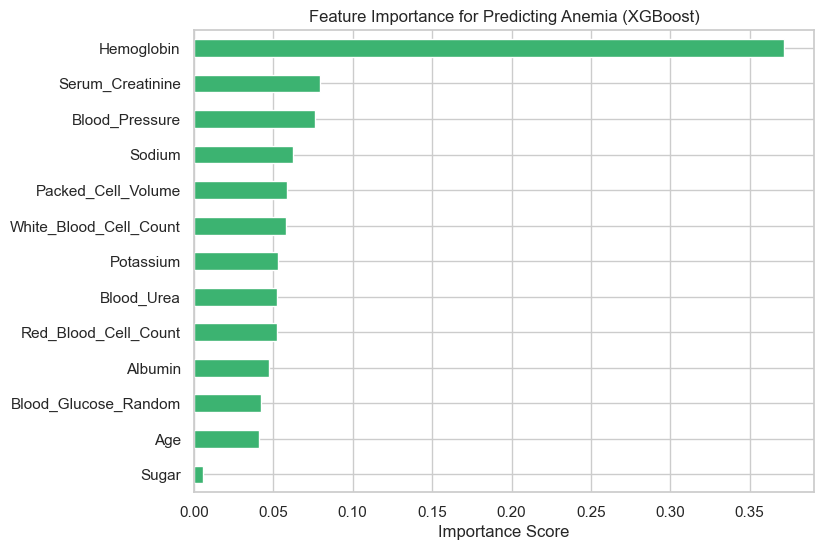

In [11]:
importance = pd.Series(model.feature_importances_, index=features).sort_values()

plt.figure(figsize=(8, 6))
importance.plot(kind="barh", color="mediumseagreen")
plt.title("Feature Importance for Predicting Anemia (XGBoost)")
plt.xlabel("Importance Score")
plt.show()

## Save Model

In [12]:
os.makedirs("../models", exist_ok=True)
joblib.dump(model, "../models/anemia_xgboost_model.joblib")
joblib.dump(scaler, "../models/anemia_scaler.joblib")
print("Model and scaler saved to 'models' folder")

Model and scaler saved to 'models' folder


# Reasoning behind using xgboost for anemia

I decided to use XGBoost instead of logistic regression for predicting anemia because it just makes more sense for this kind of data. Logistic regression is cool for basic stuff, but it assumes everything is nice and linear — and real-world medical data is rarely that simple.

In this case, things like hemoglobin, red blood cells, and other lab values probably interact with each other in weird ways that logistic regression might miss. XGBoost is better at picking up on those complex patterns without me having to manually combine features or do a ton of prep.

Plus, it’s more forgiving if the data isn’t perfect — like if there are outliers or missing values. And one thing I really like is that it tells you which features actually matter, which is super helpful when you're trying to understand what might be contributing to anemia.

So yeah, XGBoost just gives me more flexibility and tends to perform better out of the box, especially with data like this.

# Understanding the result

Basically, the model is doing what we’d expect — it heavily relies on hemoglobin (which makes total sense), and then looks at things like kidney function, blood pressure, and volume-related metrics to fill in the rest. The fact that features like sugar or age rank low means they probably don’t vary much between patients with and without anemia, at least in this dataset.